In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')

In [26]:
tweets = pd.read_csv("data_tweets_with_valence.csv")
tweets.head()

Unnamed: 0                   id             user_name  \
0           0  1340539111971516416            Rachel Roh   
1           1  1338158543359250433           Albert Fong   
2           2  1337858199140118533              eli🇱🇹🇪🇺👌   
3           3  1337855739918835717         Charles Adler   
4           4  1337854064604966912  Citizen News Channel   

               user_location  \
0  La Crescenta-Montrose, CA   
1          San Francisco, CA   
2                   Your Bed   
3     Vancouver, BC - Canada   
4                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet predicted_sentiments nltk_sentiments  
0         0          0       False             Negative        Positive  
1         1          1       False             Negative        Negative  
2         0          0       False             Negative        Positive  
3       446       2129       False             Positive         Neutral  
4         0          0       False             Negative         Neutral

# Data Cleaning

In [27]:
#changing text to lowercase
tweets["text"] = tweets["text"].str.lower()
tweets["hashtags"] = tweets["hashtags"].str.lower()
tweets["user_description"] = tweets["user_description"].str.lower()

In [28]:
#creating new column called "bipartisan"
tweets["bipartisan"] = "no"

In [29]:
#editing "bipartisan" column
politics = ["biden", "harris", "bidenharris", "joe biden", "joebiden", "kamala harris", "kamalaharris", "democrat", "liberal", "left", "trump", "pence", "trumppence", "donald trump", "donaldtrump", "mike pence", "mikepence", "republican", "GOP", "conservative", "right"]

cols_list = ["user_description", "text", "hashtags"]
pol_df = tweets[tweets[cols_list].stack().str.contains("|".join(politics), case = False, na = False).any(level = 0)]
pol_df.loc[:, "bipartisan"] = "yes"
tweets.loc[tweets.id.isin(pol_df.id), ["bipartisan"]] = pol_df["bipartisan"]
tweets.head()


Unnamed: 0                   id             user_name  \
0           0  1340539111971516416            Rachel Roh   
1           1  1338158543359250433           Albert Fong   
2           2  1337858199140118533              eli🇱🇹🇪🇺👌   
3           3  1337855739918835717         Charles Adler   
4           4  1337854064604966912  Citizen News Channel   

               user_location  \
0  La Crescenta-Montrose, CA   
1          San Francisco, CA   
2                   Your Bed   
3     Vancouver, BC - Canada   
4                        NaN   

                                    user_description         user_created  \
0  aggregator of asian american news; scanning di...  2009-04-08 17:52:46   
1  marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  hosting "charlesadlertonight" global news radi...  2008-09-10 11:28:53   
4  citizen news channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  while the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #sputnikv #astrazeneca #pfizerbio...   
3  2020-12-12 20:23:59  facts are immutable, senator, even when you're...   
4  2020-12-12 20:17:19  explain to me again why we need a vaccine @bor...   

                                            hashtags               source  \
0                                 ['pfizerbiontech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'sputnikv', 'astrazeneca', 'pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'pfizerbiontech']   Twitter for iPhone   

   retweets  favorites  is_retweet predicted_sentiments nltk_sentiments  \
0         0          0       False             Negative        Positive   
1         1          1       False             Negative        Negative   
2         0          0       False             Negative        Positive   
3       446       2129       False             Positive         Neutral   
4         0          0       False             Negative         Neutral   

  bipartisan  
0         no  
1         no  
2         no  
3         no  
4         no

# Statistical Analysis

In [30]:
from scipy import stats
pol_yes = tweets[tweets["bipartisan"] == "yes"]
pol_no = tweets[tweets["bipartisan"] == "no"]

In [31]:
#two-sided hypothesis test using t-distribution for difference in average retweets between tweets that contain and don't contain bipartisan language
mu1_r = pol_yes["retweets"].mean()
mu2_r = pol_no["retweets"].mean()
sd1_r = pol_yes["retweets"].std()
sd2_r = pol_no["retweets"].std()

stats.ttest_ind_from_stats(mean1 = mu1_r, std1 = sd1_r, nobs1 = len(pol_yes),
                          mean2 = mu2_r, std2 = sd2_r, nobs2 = len(pol_no))


Ttest_indResult(statistic=-2.0383674916025267, pvalue=0.04151830315798699)

In [32]:
#95% confidence intervals using t-distribution for average retweets 
tci = stats.t.interval(alpha = 0.95, df = len(pol_yes)-1, loc = mu1_r, scale = sd1_r/np.sqrt(len(pol_yes)))
print("95% confidence interval with t distribution for tweets with bipartisan language: ", tci )
tci = stats.t.interval(alpha = 0.95, df = len(pol_no)-1, loc = mu2_r, scale = sd2_r/np.sqrt(len(pol_no)))
print("95% confidence interval with t distribution for tweets without bipartisan language: ", tci )

95% confidence interval with t distribution for tweets with bipartisan language:  (1.1860449201229584, 1.8046375276232014)
95% confidence interval with t distribution for tweets without bipartisan language:  (2.7602867380425593, 3.733713810237738)


In [33]:
#effect size for average retweets
effect = abs(pol_yes["retweets"].mean() - pol_no["retweets"].mean())
print("average retweets for tweets that contain bipartisan language:", pol_yes["retweets"].mean())
print("average retweets for tweets that don't contain bipartisan language:", pol_no["retweets"].mean())
print("effect size:", effect)

average retweets for tweets that contain bipartisan language: 1.4953412238730799
average retweets for tweets that don't contain bipartisan language: 3.2470002741401487
effect size: 1.7516590502670688


In [34]:
#two-sided hypothesis test using t-distribution for difference in average favorites between tweets that contain and don't contain bipartisan language
mu1_f = pol_yes["favorites"].mean()
mu2_f = pol_no["favorites"].mean()
sd1_f = pol_yes["favorites"].std()
sd2_f = pol_no["favorites"].std()

stats.ttest_ind_from_stats(mean1 = mu1_f, std1 = sd1_f, nobs1 = len(pol_yes),
                          mean2 = mu2_f, std2 = sd2_f, nobs2 = len(pol_no))


Ttest_indResult(statistic=-1.9226028988056116, pvalue=0.05453546040049159)

In [35]:
#95% confidence intervals using t-distribution for average favorites
tci = stats.t.interval(alpha = 0.95, df = len(pol_yes)-1, loc = mu1_f, scale = sd1_f/np.sqrt(len(pol_yes)))
print("95% confidence interval with t distribution for tweets with bipartisan language: ", tci )
tci = stats.t.interval(alpha = 0.95, df = len(pol_no)-1, loc = mu2_f, scale = sd2_f/np.sqrt(len(pol_no)))
print("95% confidence interval with t distribution for tweets without bipartisan language: ", tci )

95% confidence interval with t distribution for tweets with bipartisan language:  (5.5403343616407055, 9.730378305193845)
95% confidence interval with t distribution for tweets without bipartisan language:  (12.079258532639333, 15.774814557341898)


In [36]:
#effect size for average favorites
effect = abs(pol_yes["favorites"].mean() - pol_no["favorites"].mean())
print("average favorites for tweets that contain bipartisan language:", pol_yes["favorites"].mean())
print("average favorites for tweets that don't contain bipartisan language:", pol_no["favorites"].mean())
print("effect size:", effect)

average favorites for tweets that contain bipartisan language: 7.635356333417275
average favorites for tweets that don't contain bipartisan language: 13.927036544990615
effect size: 6.291680211573341


In [37]:
#proportion of bipartisan/non-bipartisan tweets that are positive
pol_yes_pos = pol_yes[pol_yes["nltk_sentiments"] == "Positive"]
p = len(pol_yes_pos)/len(pol_yes)
print("Observed proportion of bipartisan tweets that are positive:", p)
s = math.sqrt(p*(1-p))

pol_no_pos = pol_no[pol_no["nltk_sentiments"] == "Positive"]
p2 = len(pol_no_pos)/len(pol_no)
print("Observed proportion of non-bipartisan tweets that are positive:", p2)
s2 = math.sqrt(p2*(1-p2))

print(stats.ttest_ind_from_stats(mean1 = p, std1 = s, nobs1 = len(pol_yes),
                          mean2 = p2, std2 = s2, nobs2 = len(pol_no)))

Observed proportion of bipartisan tweets that are positive: 0.3825232938806346
Observed proportion of non-bipartisan tweets that are positive: 0.3673688872018726
Ttest_indResult(statistic=1.9016325873951478, pvalue=0.05722479140798245)


In [38]:
#proportion of bipartisan/non-bipartisan tweets that are negative
pol_yes_neg = pol_yes[pol_yes["nltk_sentiments"] == "Negative"]
p = len(pol_yes_neg)/len(pol_yes)
print("Observed proportion of bipartisan tweets that are negative:", p)
s = math.sqrt(p*(1-p))

pol_no_neg = pol_no[pol_no["nltk_sentiments"] == "Negative"]
p2 = len(pol_no_neg)/len(pol_no)
print("Observed proportion of non-bipartisan tweets that are negative:", p2)
s2 = math.sqrt(p2*(1-p2))

print(stats.ttest_ind_from_stats(mean1 = p, std1 = s, nobs1 = len(pol_yes),
                          mean2 = p2, std2 = s2, nobs2 = len(pol_no)))

Observed proportion of bipartisan tweets that are negative: 0.21782926215059178
Observed proportion of non-bipartisan tweets that are negative: 0.18245081293097995
Ttest_indResult(statistic=5.514718766095885, pvalue=3.5101532470417246e-08)


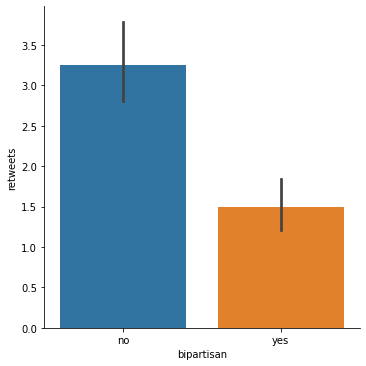

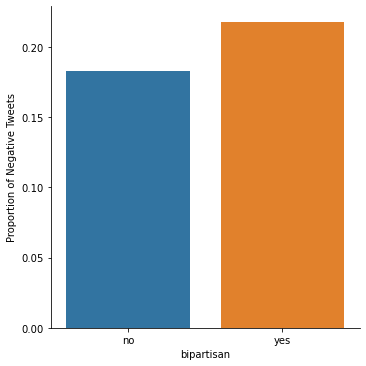

In [39]:
#Visualizations
sns.catplot(data = tweets, x = "bipartisan", y = "retweets", kind = "bar")

proportion_df = pd.DataFrame()
proportion_df["bipartisan"] = pd.Series(["no", "yes"])
proportion_df["Proportion of Negative Tweets"] = pd.Series([p2, p])
proportion_df.head()

sns.catplot(data = proportion_df, x = "bipartisan", y = "Proportion of Negative Tweets", kind = "bar")